# Test difference between my tables and Steve's tables

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [37]:
import numpy as np
import h5py
from tov import TableStar, BaseStar
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d

class TestTable(TableStar):

    """Docstring for TestTable. """

    def __init__(self, tablefile, scaling = {}, *args, **kwargs):
        """Assumes cold star, i.e minimal T. 
        
        Scales to geometrized units c = G = M_sun = 1
        """
        BaseStar.__init__(self, *args, **kwargs)
        self._allow_negative_pressure = True

        f = h5py.File(tablefile, 'r')
        
        self.scaling = {}
        
        # default scaling is  c = G = M_sun = 1
        default_scaling = {'pres'  : 1.801569643420104e-39, # from dyn/cm^2
                           'rho'   : 1.6191700468788605e-18, # from g/cm^3
                           'specific_energy': 1.11265005605e-21,  # from erg/g
                           # munu should be MeV/baryon
                          }
        default_scaling.update(scaling)
        self.scaling.update(default_scaling)
        
        self.ye_arr   = f['ye'][:] 
        self.rho_arr  = f['logrho'][:] + np.log10(self.scaling['rho'])
        
        self.energy_shift  = f['energy_shift'][0] * self.scaling['specific_energy']

        rho_grid, ye_grid  = np.meshgrid(self.rho_arr, self.ye_arr)
        pres_values   = f['logpress'][:,0,:]  + np.log10(self.scaling['pres'])
        munu_values   = f['munu'][:,0,:]      # *          self.scaling['energy']
        energy_values = f['logenergy'][:,0,:] + np.log10(self.scaling['specific_energy']) 
        f.close()

        self.ye_bounds   = (np.min(self.ye_arr),  np.max(self.ye_arr))
        self.rho_bounds  = (np.min(self.rho_arr), np.max(self.rho_arr))
        self.pres_bounds = (np.min(pres_values),  np.max(pres_values))

        self.energy_arr = np.zeros_like(self.rho_arr)
        self.pres_arr   = np.zeros_like(self.rho_arr)

        prev_root = 0 
        
        # for each rho, extract the values given ye such that munu = 0
        for i, rho in enumerate(self.rho_arr):
            munu_func   = InterpolatedUnivariateSpline(self.ye_arr, munu_values[:,i])
            pres_func   = interp1d(self.ye_arr, pres_values[:,i])
            energy_func = interp1d(self.ye_arr, energy_values[:,i])
            
            ye_roots = munu_func.roots()
            
            
            if len(ye_roots) > 1:
                # in case several roots, we pick the closest one
                import warnings
                warnings.warn('Error, more than one root in munu! Using closest to previous')
                i_root = np.argmin(np.abs(np.array(ye_roots) - prev_root))
            else:
                i_root = 0
                
            ye_root = ye_roots[i_root]
            prev_root = ye_root
            
            self.pres_arr[i] = pres_func(ye_root)
            self.energy_arr[i] = energy_func(ye_root)
            
        self.rho_interp    = interp1d(self.pres_arr, self.rho_arr, fill_value='extrapolate')
        self.pres_interp   = interp1d(self.rho_arr, self.pres_arr, fill_value='extrapolate')
        self.energy_interp = interp1d(self.rho_arr, self.energy_arr, fill_value='extrapolate')
            
    def energy(self, rho):
        logrho = np.log10(rho)
        return 10**self.energy_interp(logrho) - self.energy_shift
    
    def P(self, rho):
        # a, b = self.ye_bounds
        logrho = np.log10(rho)
        # res = scipy.optimize.bisect(self.munu, a = a, b = b, args=(logrho, 'rho'))
        # self.current_ye = res
        return 10**self.pres_interp(logrho)
    
    def rho(self, P):
        # a, b = self.ye_bounds
        logP = np.log10(P)
        # res = scipy.optimize.bisect(self.munu, a = a, b = b,  args=(logP, 'pres'))
        # self.current_ye = res
        return 10**self.rho_interp(logP)
    
    def rho0(self, P, rho = None):
        """Uses P as is, no convert to log"""
        rho = rho or self.rho(P)
        eps = self.energy(rho)
        return rho / (1 + eps)

/home/halvard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Error, more than one root in munu! Using closest to previous


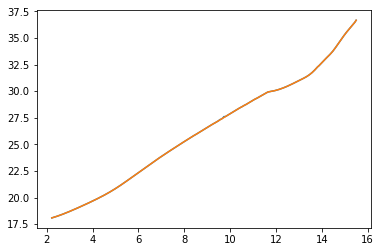

In [36]:
import h5py
fname ='eos_dat/Hempel_SFHoEOS_rho222_temp180_ye60_version_1.1_20120817.h5.dat'
# tab = h5py.File(fname)
a = np.loadtxt(fname).T
plt.plot(a[1], a[0])


test = TestTable(h5_file)
x = test.rho_arr 
f = test.pres_interp
y = f(x)
x_cgs = x - np.log10(test.scaling['rho'])
y_cgs = y - np.log10(test.scaling['pres'])
plt.plot(x_cgs, y_cgs)

In [4]:
h5_file = 'test/Hempel_SFHoEOS_rho222_temp180_ye60_version_1.1_20120817.h5'

Text(0.5,0,'ye')

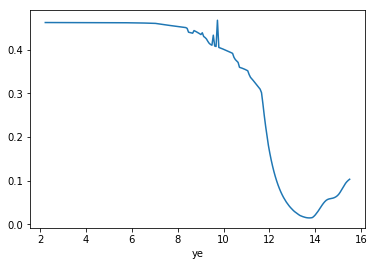

In [132]:
plt.plot(data[1], data[-1])
plt.xlabel('rho')
plt.xlabel('ye')

In [49]:
data = np.loadtxt(fname).T

# first line contains energy shift
with open(fname) as infile:
    line = infile.readline()
    energy_shift = float(line.split()[4])

# Scaling from cgs to c=G=Msun=1
scaling = {'pres'  : 1.801569643420104e-39, # from dyn/cm^2
           'rho'   : 1.6191700468788605e-18, # from g/cm^3
           'eps'   : 1.11265005605e-21,  # from erg/g 
               }
logP = data[0] + np.log10(scaling['pres'])
logrho = data[1] + np.log10(scaling['rho'])
logeps = data[2] + np.log10(scaling['eps']) 

energy_interp = interp1d(logrho, logeps)
# self.energy_interp = interp1d(logrho, logrho)

In [170]:
import numpy as np
import h5py
from tov import TableStar, BaseStar
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d

class PremadeTable(BaseStar):
    def __init__(self, tablefile, scaling = {}, *args, **kwargs):
        BaseStar.__init__(self, *args, **kwargs)
        self._allow_negative_pressure = True

        # Scaling from cgs to c=G=Msun=1
        scaling = {'pres': 1.801569643420104e-39, # from dyn/cm^2
                    'rho': 1.6191700468788605e-18, # from g/cm^3
                    'eps': 1.11265005605e-21,  # from erg/g 
                  }
        
        data = np.loadtxt(tablefile).T

        # first line contains energy shift
        with open(tablefile) as infile:
            line = infile.readline()
            self.energy_shift = float(line.split()[4]) * scaling['eps']

        logpres = data[0] + np.log10(scaling['pres'])
        logrho = data[1] + np.log10(scaling['rho'])
        logeps = data[2] + np.log10(scaling['eps']) 
        self.pres_bounds = (np.min(logpres), np.max(logpres))

        self.eps_interp  = interp1d(logrho, logeps, fill_value ='extrapolate')
        self.rho_interp  = interp1d(logpres, logrho, fill_value ='extrapolate')
        self.pres_interp = interp1d(logrho, logpres, fill_value ='extrapolate')
        
            
    def energy(self, rho):
        logrho = np.log10(rho)
        return 10**self.eps_interp(logrho) - self.energy_shift
    
    def P(self, rho):
        # a, b = self.ye_bounds
        logrho = np.log10(rho)
        # res = scipy.optimize.bisect(self.munu, a = a, b = b, args=(logrho, 'rho'))
        # self.current_ye = res
        return 10**self.pres_interp(logrho)
    
    def rho(self, P):
        # a, b = self.ye_bounds
        logP = np.log10(P)
        # res = scipy.optimize.bisect(self.munu, a = a, b = b,  args=(logP, 'pres'))
        # self.current_ye = res
        return 10**self.rho_interp(logP)
    
    def rho0(self, P, rho = None):
        """Uses P as is, no convert to log"""
        rho = rho or self.rho(P)
        eps = self.energy(rho)
        return rho / (1 + eps)

['Hempel_TMAEOS_rho234_temp180_ye60_version_1.1_20120817.h5.dat', 'Hempel_SFHoEOS_rho222_temp180_ye60_version_1.1_20120817.h5.dat', 'Hempel_TM1EOS_rho234_temp180_ye60_version_1.1_20120817.h5.dat', 'LS220_3335_rho391_temp163_ye66.h5.dat', 'Hempel_SFHxEOS_rho234_temp180_ye60_version_1.1_20120817.h5.dat']
eos_dat/Hempel_SFHoEOS_rho222_temp180_ye60_version_1.1_20120817.h5.dat


/home/halvard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in log10


KeyboardInterrupt: 

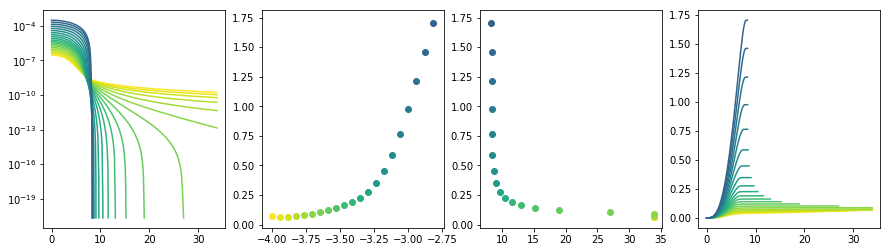

In [214]:
from test_table import run_star
fvals = []
filenames = ['Hempel_SFHoEOS_rho222_temp180_ye60_version_1.1_20120817.h5.dat',
             'Hempel_SFHxEOS_rho234_temp180_ye60_version_1.1_20120817.h5.dat',
             'Hempel_TM1EOS_rho234_temp180_ye60_version_1.1_20120817.h5.dat',
             'Hempel_TMAEOS_rho234_temp180_ye60_version_1.1_20120817.h5.dat',
             'LS220_3335_rho391_temp163_ye66.h5.dat']
short_names = ['LS220','SFHo','SFHx','TM1','TMA']

print(table_names)
rho_values = np.linspace(-4, -2.2905, 30)

for fname, sname in zip(filenames, short_names):
    print('eos_dat/' + fname)
    test = PremadeTable('eos_dat/' + fname)
    
    # this line runs everything
    res = run_star(test, rho_values = rho_values)
    fvals.append(res)
    
    fig = plt.gcf()
    fig.suptitle(sname)
    fig.tight_layout()

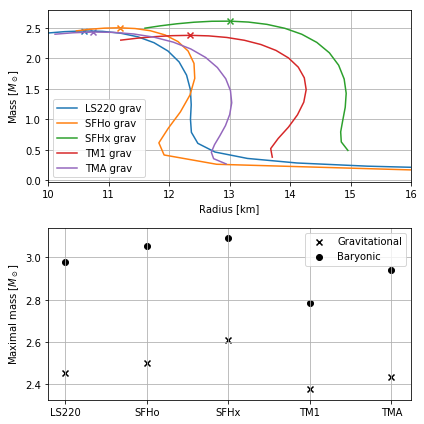

In [212]:
fig, [ax1,ax2] = plt.subplots(2, figsize = [6,6])
for i, (final_values, sname) in enumerate(zip(fvals, short_names)):
    rho, r_values, m_values, P_values, phi_values, M0_values = np.array(final_values).T
    to_km = 1e-5/6.7706e-6

    c = 'C{}'.format(i)
    ax1.plot(to_km*r_values, m_values, '-', color = c, label = sname + ' grav')
    
    i_max = np.argmax(m_values)
    assert (i_max == np.argmax(M0_values))
    
    m_max = m_values[i_max]
    M0_max = M0_values[i_max]
    ax1.scatter(to_km*r_values[i_max], m_max, c = c, marker = 'x')
    # ax1.scatter(to_km*r_values[i_max], M0_max, c = c, marker = 'o')
    ax2.scatter(i, m_max, c = 'k', marker = 'x')
    ax2.scatter(i, M0_max, c = 'k', marker = 'o')
    
ax2.set_xticks(range(len(short_names)))
ax2.set_xticklabels(short_names)
ax1.legend()
ax2.legend(['Gravitational','Baryonic'])
ax1.grid()
ax2.grid()

ax1.set_xlabel('Radius [km]')
ax1.set_ylabel(r'Mass [$M_\odot$]')
ax2.set_ylabel(r'Maximal mass [$M_\odot$]')

ax1.set_xlim([10,16])
fig.tight_layout()
# ax2.legend('')